# Inverter Based Amplifier Parameters Calculation

## Architecture:
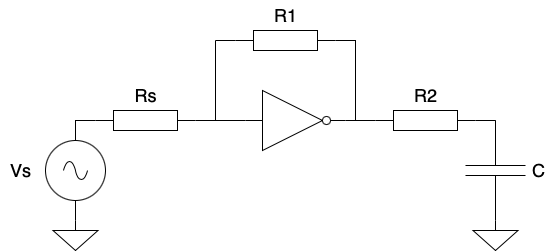

### Using the driving point signal flow graph of this circuit, we find the transfer function easily. For more information about this technique, see: Schmid, Hanspeter, et Alex Huber. « Analysis of Switched-Capacitor Circuits Using Driving-Point Signal-Flow Graphs ». Analog Integrated Circuits and Signal Processing 96, nᵒ 3 (septembre 2018): 495‑507. https://doi.org/10.1007/s10470-018-1131-7.


## Transfer function and signal flow graph

### TODO IMAGE OF SFG

In [1]:
import sympy as sp

Delta = sp.symbols('Delta')
L1,L2 = sp.symbols('L1,L2')
T_num = sp.symbols('T_num')
T_den = sp.symbols('T_den')
T_io = sp.symbols('T_io')

R_s,G_dsp,C_1,G_mn,R_L,C_gsp,C_gsn,G_dsn,s,G_mp,R_2,R_1 = sp.symbols('R_s,G_dsp,C_1,G_mn,R_L,C_gsp,C_gsn,G_dsn,s,G_mp,R_2,R_1')


In [2]:
loops = [(L1, (-G_mn - G_mp)/(R_1*(G_dsn + G_dsp + 1/R_2 + 1/R_1)*(C_gsn*s + C_gsp*s + 1/R_s + 1/R_1))), (L2, 1/(R_2**2*(C_1*s + 1/R_L + 1/R_2)*(G_dsn + G_dsp + 1/R_2 + 1/R_1)))]
determinant = [(Delta, -L1 - L2 + 1)]
denominator = [(T_den, Delta)]

In [3]:
P1,D1 = sp.symbols('P1,D1')
paths = [(P1, (-G_mn - G_mp)/(R_2*R_s*(C_1*s + 1/R_L + 1/R_2)*(G_dsn + G_dsp + 1/R_2 + 1/R_1)*(C_gsn*s + C_gsp*s + 1/R_s + 1/R_1))), (D1, 1)]
numerator = [(T_num, D1*P1)]

In [4]:
transfer_function = [(T_io, T_num/T_den)]
T=T_io.subs(transfer_function).subs(numerator).subs(denominator).subs(determinant).subs(paths).subs(loops).simplify()

# In our case we consider Rs close to 0 and Rl close to infinit 
T = T.subs(R_s,0).simplify()
T = T.limit(R_L, sp.oo).simplify()

display(T)

-R_1*(G_mn + G_mp)/(C_1*G_dsn*R_1*R_2*s + C_1*G_dsp*R_1*R_2*s + C_1*R_1*s + C_1*R_2*s + G_dsn*R_1 + G_dsp*R_1 + 1)

# Operating point

I chose Vdd to be 1.5 V arbitrarly. Then, I did a simulation to find the operating point where Vin = Vout for my inverter, such that we have the maximum swing possible. Thanks to ngspice, I can from this point find the numerical values of our operating point transistors parameters.

TODO: Simulation images.

In [5]:
#Here i replace the values of the components
T = T.subs([(G_mn, 1.642537e-03),(G_mp, 1.314604e-03),(G_dsn, 9.321308e-05),
            (G_dsp, 1.683392e-04),(C_gsn,9.11685e-15),(C_gsp, 2.38214e-14)])

## Gain computation

In [6]:
#To compute our gain we want s=0
gain = T.subs(s, 0).simplify()
gain

-0.002957141*R_1/(0.00026155228*R_1 + 1)

In [7]:
# Value of R1, easy to get on schematic and gain ok by trail and error
gain = gain.subs(R_1, 6e4)
T = T.subs(R_1, 6e4)
# Evaluate the numerical value of the gain
numerical_gain = gain.evalf()
numerical_gain

-10.6288268122262

In [8]:
import math

# gain in dB
gain_db = 20 * math.log10(abs(numerical_gain))
gain_db

20.52970661295958

## Cut-Off frequency computation

In [9]:
T_den = sp.denom(T).simplify()
T_den

16.6931368*C_1*R_2*s + 60000.0*C_1*s + 16.6931368

In [10]:
cutoff_frequency = 500e3

# Update the expression with the new value of s
T_den = T_den.subs(s, 2*sp.pi*cutoff_frequency)
T_den

16693136.8*pi*C_1*R_2 + 60000000000.0*pi*C_1 + 16.6931368

In [11]:
#choosing a value for C1 by solving the denominator
R2 = 1e5
T_den = T_den.subs(R_2, R2)
C1 = sp.solve(T_den, C_1)
C1

#C1 = 2.768e-12
#T_den = T_den.subs(C_1, C1)
#R2 = sp.solve(T_den, R_2)
#R2

[-3.07265855599919e-12]

In [12]:
# As we don't have exactly same values for components,
# let's find the cutoff frequency for the values we have


T_den2 = sp.denom(T).simplify()
T_den2 = T_den2.subs([(C_1, 2.768e-12), (R_2, 1e5)])
cutoff_frequency2 = sp.solve(T_den2, s)
cutoff_frequency2 = cutoff_frequency2[0]/(2*sp.pi)
cutoff_frequency2.evalf()

-555032.253612571